## Police Stops in San Diego 2014-2017 Alogrithm Audit
> Dataset Source: https://openpolicing.stanford.edu/data/

##### David Aminifard  
##### A15451805  
##### Aaron Mcmillan Fraenkel  

# Recap & Transition

> In the prior report, "Police Stops in San Diego 2014-2017 Fairness Evalutation", we explored a police dataset to uncover whether it measures up in terms of Demographic Parity and Rawlsian Fair Equality of Opportunity. The context we provided at the beginning of the report strongly indicated that we should expect that Demographic Parity would not be met in regards to proportions of police searches and contraband being found, and it was not. To further validate our findings, we ran an A/B test to see if our findings were statistically significant, and they were. We concluded that police officers were more likely to wrongly search Blacks than Whites. In light of this, if we look at police officers as if they were classification algorithms (since they decide who to search), we have strong evidence that they have a higher failure rate for Blacks than Whites. This report will continue to analyze police officers in this manner.

> We will create a simple machine learning algorithm, which we will analyze in terms of individual fairness and intersectionality.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import warnings
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

In [2]:
enc = preprocessing.LabelEncoder()

In [3]:
def get_search_probs(df, metric):
    race_search = df[['subject_race', metric]]
    race_search[metric] = race_search[metric].apply(lambda x: 1 if x==True else 0)
    race_search_df = (race_search.groupby(['subject_race']))[metric].value_counts(normalize=True).rename('proportion').reset_index()
    race_search_df[metric] = race_search_df[metric].apply(lambda x: 'Searched' if x==1 else 'Not Searched')
    return race_search_df

In [4]:
df = pd.read_csv('ca_san_diego_2020_04_01.csv')
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['had_info'] = df['reason_for_stop'].apply(lambda x: 1 if ('info' in str(x).lower()) or 
                                             ('knowledge' in str(x).lower()) else 0)

In [5]:
features = ['hour', 
            #'subject_race', 
            #'subject_sex', 
            #'subject_age',
            'service_area',
            'day_of_week',
            'month',
            'had_info'
           ]
labels = ['search_conducted']

In [6]:
feature_df = df[features].apply(enc.fit_transform)
label_df = df[labels]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.25)

# Random Forest Classifier Assessment

> Using the sklearn package we are predicting whether someone will be searched based off factors that includes: the of the hour of the day the service area (the location of the traffic stop), the month, day of the week, and whether the officer had prior info on the individual.

> The mean accuracy, i.e. score, of the classifier is rather high. There is a strong indication from the barcharts that this simple ML algorithm perpetuates a similar lack of demographic parity as the officers themselves do, as we covered before.

> While the algorithm yields less contraband (less True Positives), it also predicts less searches that result in no contraband (Less False Positives). Unsuprisingly, it seems that this alogorithm will reflect the biased data used to build it.

In [8]:
lr = RandomForestClassifier()
lr = lr.fit(x_train, y_train)
f"Score of the classifier: {lr.score(x_test, y_test)}"

'Score of the classifier: 0.9534028843844314'

In [9]:
predicted_search = pd.Series(lr.predict(feature_df))
probs = lr.predict_proba(feature_df)
df['predicted_search'] = predicted_search
df['predicted_search_prob'] = pd.DataFrame(probs)[1]

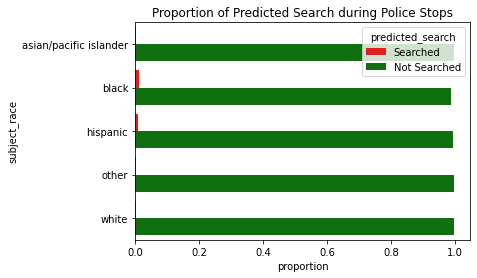

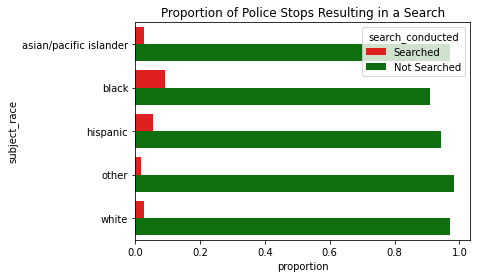

In [10]:
sns.barplot(x='proportion', y='subject_race', hue='predicted_search', data=get_search_probs(df, 'predicted_search'), hue_order=['Searched', 'Not Searched'], palette=['r','g'], orient="h").set_title("Proportion of Predicted Search during Police Stops")
plt.show()
sns.barplot(x='proportion', y='subject_race', hue='search_conducted', data=get_search_probs(df, 'search_conducted'), hue_order=['Searched', 'Not Searched'], palette=['r','g'], orient="h").set_title("Proportion of Police Stops Resulting in a Search")
plt.show()

In [11]:
curr_eval = df[['search_conducted', 'predicted_search', 'contraband_found']]

In [12]:
ps_times = curr_eval.loc[(curr_eval['contraband_found'] == curr_eval['predicted_search']) &
                         (curr_eval['contraband_found'] == True)
                 ].shape[0]

sc_times = curr_eval.loc[(curr_eval['contraband_found'] == curr_eval['search_conducted']) &
                         (curr_eval['contraband_found'] == True)
                 ].shape[0]

print(f"Number of times predicted search yielded contraband: {ps_times}")
print(f"Number of times of search conducted yielded contraband: {sc_times}")

Number of times predicted search yielded contraband: 161
Number of times of search conducted yielded contraband: 1553


In [13]:
ps_times = curr_eval.loc[(curr_eval['contraband_found'] != curr_eval['predicted_search']) &
                         (curr_eval['contraband_found'] == False)
                 ].shape[0]

sc_times = curr_eval.loc[(curr_eval['contraband_found'] != curr_eval['search_conducted']) &
                         (curr_eval['contraband_found'] == False)
                 ].shape[0]

print(f"Number of times predicted search yielded no contraband: {ps_times}")
print(f"Number of times of search conducted yielded no contraband: {sc_times}")

Number of times predicted search yielded no contraband: 1053
Number of times of search conducted yielded no contraband: 14735


# Intersectionality Analysis

> We will see if intersectional categories compound. We can see that the fields subject_sex and is_black have a high impact on the results, i.e. probability of the algorithm yielding searched==True, given the magnitude of subject_sex[T.male]:is_black coefficient. It seems that the two fields are correlated.

In [14]:
df['is_black'] = df['subject_race'].apply(lambda x: 1 if x=='black' else 0)
df['search_conducted'] = df['search_conducted'].apply(lambda x: 1 if x==True else 0)

In [15]:
formula = "predicted_search_prob ~ is_black + subject_age + subject_sex + subject_sex:is_black + subject_age:is_black"
model = smf.ols(formula=formula, data=df).fit()
summary = model.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0482,0.000,100.564,0.000,0.047,0.049
subject_sex[T.male],0.0086,0.000,26.814,0.000,0.008,0.009
is_black,0.0179,0.001,12.021,0.000,0.015,0.021
subject_sex[T.male]:is_black,0.0057,0.001,5.673,0.000,0.004,0.008
subject_age,-0.0004,1.08e-05,-35.017,0.000,-0.000,-0.000
subject_age:is_black,0.0002,3.41e-05,5.377,0.000,0.000,0.000


> The bar charts below show that bias in the police data does indeed continue in the machine learning algorithm. The algorithm is much more likely to yield a search for Blacks who are below the age of 25 than any other recorded demographic.

> Interestingly, the ROC curve below shows that the model works best for Whites who are between the ages 25 - 45 and worst for Blacks who are over the age of 45 (based on the AUC). 

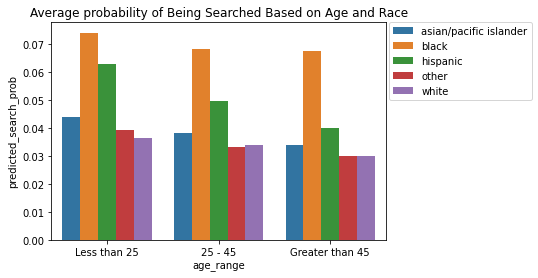

In [16]:
def get_age_range(x):
    if x < 25:
        return "Less than 25"
    elif x >= 25 and x <= 45:
        return "25 - 45"
    elif x > 45:
        return "Greater than 45"
    else:
        return np.NaN

inter = df[['subject_age', 'subject_sex', 'subject_race', 'predicted_search_prob']]
inter['age_range'] = inter['subject_age'].apply(get_age_range)
inter=inter.groupby(['age_range', 'subject_race']).mean().reset_index()
sns.barplot(x='age_range', 
            y='predicted_search_prob', 
            hue='subject_race', 
            data=inter, 
            order=["Less than 25", "25 - 45", "Greater than 45"]
           ).set_title("Average probability of Being Searched Based on Age and Race")
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.show()

In [54]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import confusion_matrix
probas = lr.predict_proba(x_test)[:, 1]
races = df['subject_race'].unique().tolist()[:-1]

df['age_range'] = df['subject_age'].apply(get_age_range)

def plot_roc(df):

    f = plt.figure()
    f.set_figwidth(8)
    f.set_figheight(7)

    for race in ['white', 'black']:
        for age in ['Less than 25', '25 - 45', 'Greater than 45']:

            f_df = df.loc[(df['subject_race']==race) &
                          (df['age_range']==age)
                         ][features].apply(enc.fit_transform)
            l_df = df.loc[(df['subject_race']==race) &
                          (df['age_range']==age)
                         ][labels]

            probs = lr.predict_proba(f_df)  
            probs = probs[:, 1]  
            fper, tper, thresholds = roc_curve(l_df.to_numpy(), probs) 

            plt.plot(fper, tper, label=f'{race.capitalize()} & {age}, AUC: {round(auc(fper, tper), 4)}')


    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Police Search by Race and Age (ROC) Curve')
    plt.legend(bbox_to_anchor=(1.01, 1),
               borderaxespad=0)

    plt.show()

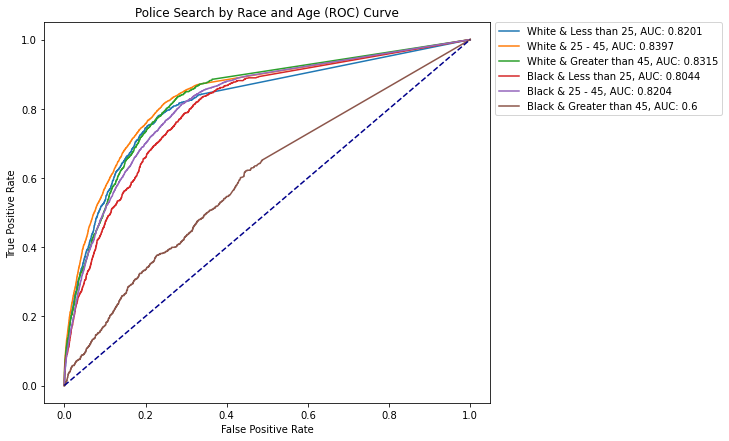

In [55]:
plot_roc(df)

# Individual Fairness